## Imports

In [1]:
from PIL import Image
import glob
import re
import json
from pathlib import Path
import matplotlib.pyplot as plt

## Crop

### Create cropped images and save them

In [2]:
image_list = []
resized_images = []

for filename in glob.glob('imgOld/*.png'): #images to be cropped put in folder called 'imgOld'
    resized_images = []
    im = Image.open(filename)
    im1 = im.crop((0,0,512,512)) #top left
    im2 = im.crop((512,0,1024,512)) #top right
    im3 = im.crop((0,512,512,1024)) #bottom left
    im4 = im.crop((512,512,1024,1024)) #bottom right
    resized_images.append(im1)
    resized_images.append(im2)
    resized_images.append(im3)
    resized_images.append(im4)
    for i in range(4):
        new_int = ((int(re.match('(patch)(\d+)', Path(filename).stem)[2])-1)*4)+i+1 #new image id number
        new_id = f'sq{new_int}.png'
        cropped_img = resized_images[i]
        cropped_img.save("imgCrop/"+new_id) #new cropped images put in folder called 'imgCrop' (this then re-named to 'img')

### Create new json from old json

In [3]:
with open('old_circles.json', 'r') as f:
    circles_te = json.load(f)

new_list_te = []
cut_offs = [[(0,511),(0,511)], [(512,1023),(0,511)], [(0,511),(512,1023)], [(512,1023),(512,1023)]] #cut-off points that define 4 quadrants
for j,circles_dict in enumerate(circles_te):
    for i in range(4): #0->3 (for each quadrant)
        new_int = ((int(re.match('(patch)(\d+)(.png)', circles_dict['sq_id'])[2])-1)*4)+i+91
        new_id = f'sq{new_int}.png'
        
        #get x and y low and high limits:
        x_low, x_high = cut_offs[i][0]
        y_low, y_high = cut_offs[i][1]
        
        #change the x and y coordinates of points such that they refer to position in 512px by 512px quadrant of image not the position in the 1024px by 1024px image:
        new_points = []
        for point in circles_dict['points']:
            cx = point['cx']
            cy = point['cy']
            if (x_low < cx) and (x_high > cx) and (y_low < cy) and (y_high > cy): #if point beyond limits of this quadrant:
                new_points.append({'name': 'circle',
                                  'cx': cx%512, 'cy': cy%512,
                                  'r' : point['r']}) #e.g 514%512 = 2
                
        new_list_te.append({'sq_id': new_id, 'points': new_points})
        
#Write new json from array:
with open("new_circles.json", 'w') as f:
    json.dump(new_list_te, f)

### Check output

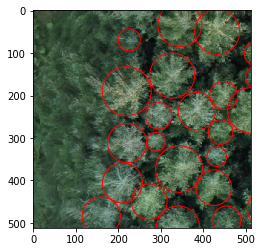

In [5]:
image = Image.open('./imgCrop/sq91.png')
plt.imshow(image)
for point_dict in circles_te[0]['points']:
    circ = plt.Circle((point_dict['cx'], point_dict['cy']), point_dict['r'], color = 'r', fill = False)
    plt.gcf().gca().add_artist(circ)